## Programming Assignment 2:

Classification Task and Performance Evaluation (10 points)

Importing required libraries

In [1]:
import os
import shutil
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix

import warnings

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

base_path = "/content/drive/My Drive/DogClassifier"
image_path = os.path.join(base_path, "Images")
grayscale_path = os.path.join(base_path, "Grayscale")
standardized_path = os.path.join(base_path, "Standardized")
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
annotations_path = os.path.join(base_path, "Annotations")

repo_path = "/content/dataset"


def is_dir_empty(path):
    return not os.listdir(path)


def copy_data(src, dest):
    try:
        shutil.copytree(src, dest)
        print(f"Data copied successfully from {src} to {dest}.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


if not os.path.exists(image_path) or not os.path.exists(annotations_path) or is_dir_empty(image_path) or is_dir_empty(
        annotations_path):
    if os.path.exists(image_path):
        shutil.rmtree(image_path)
    if os.path.exists(annotations_path):
        shutil.rmtree(annotations_path)

    if not os.path.exists(repo_path):
        os.system(f"git clone https://github.com/Sairam-KSR/Data_Mining.git {repo_path}")
        print("Repository cloned successfully.")
    else:
        print("Repository already exists. Skipping cloning.")

    copy_data(os.path.join(repo_path, 'Images'), image_path)
    copy_data(os.path.join(repo_path, 'Annotations'), annotations_path)
else:
    print("The required folders already exist in Google Drive and are not empty. Skipping cloning and copying.")


Mounted at /content/drive
The required folders already exist in Google Drive and are not empty. Skipping cloning and copying.


## Task 1.
Use images from ALL FOUR classes. Convert the images to grayscale pixel intensity histograms. (These will be the vector representations of the images). This will be your dataset for Part 2. (0.25 point)

Total files found: 751
Total histograms saved: 751


<ipython-input-8-6f5451485d4e>:68: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((256, 256), Image.ANTIALIAS)  # Resize the image


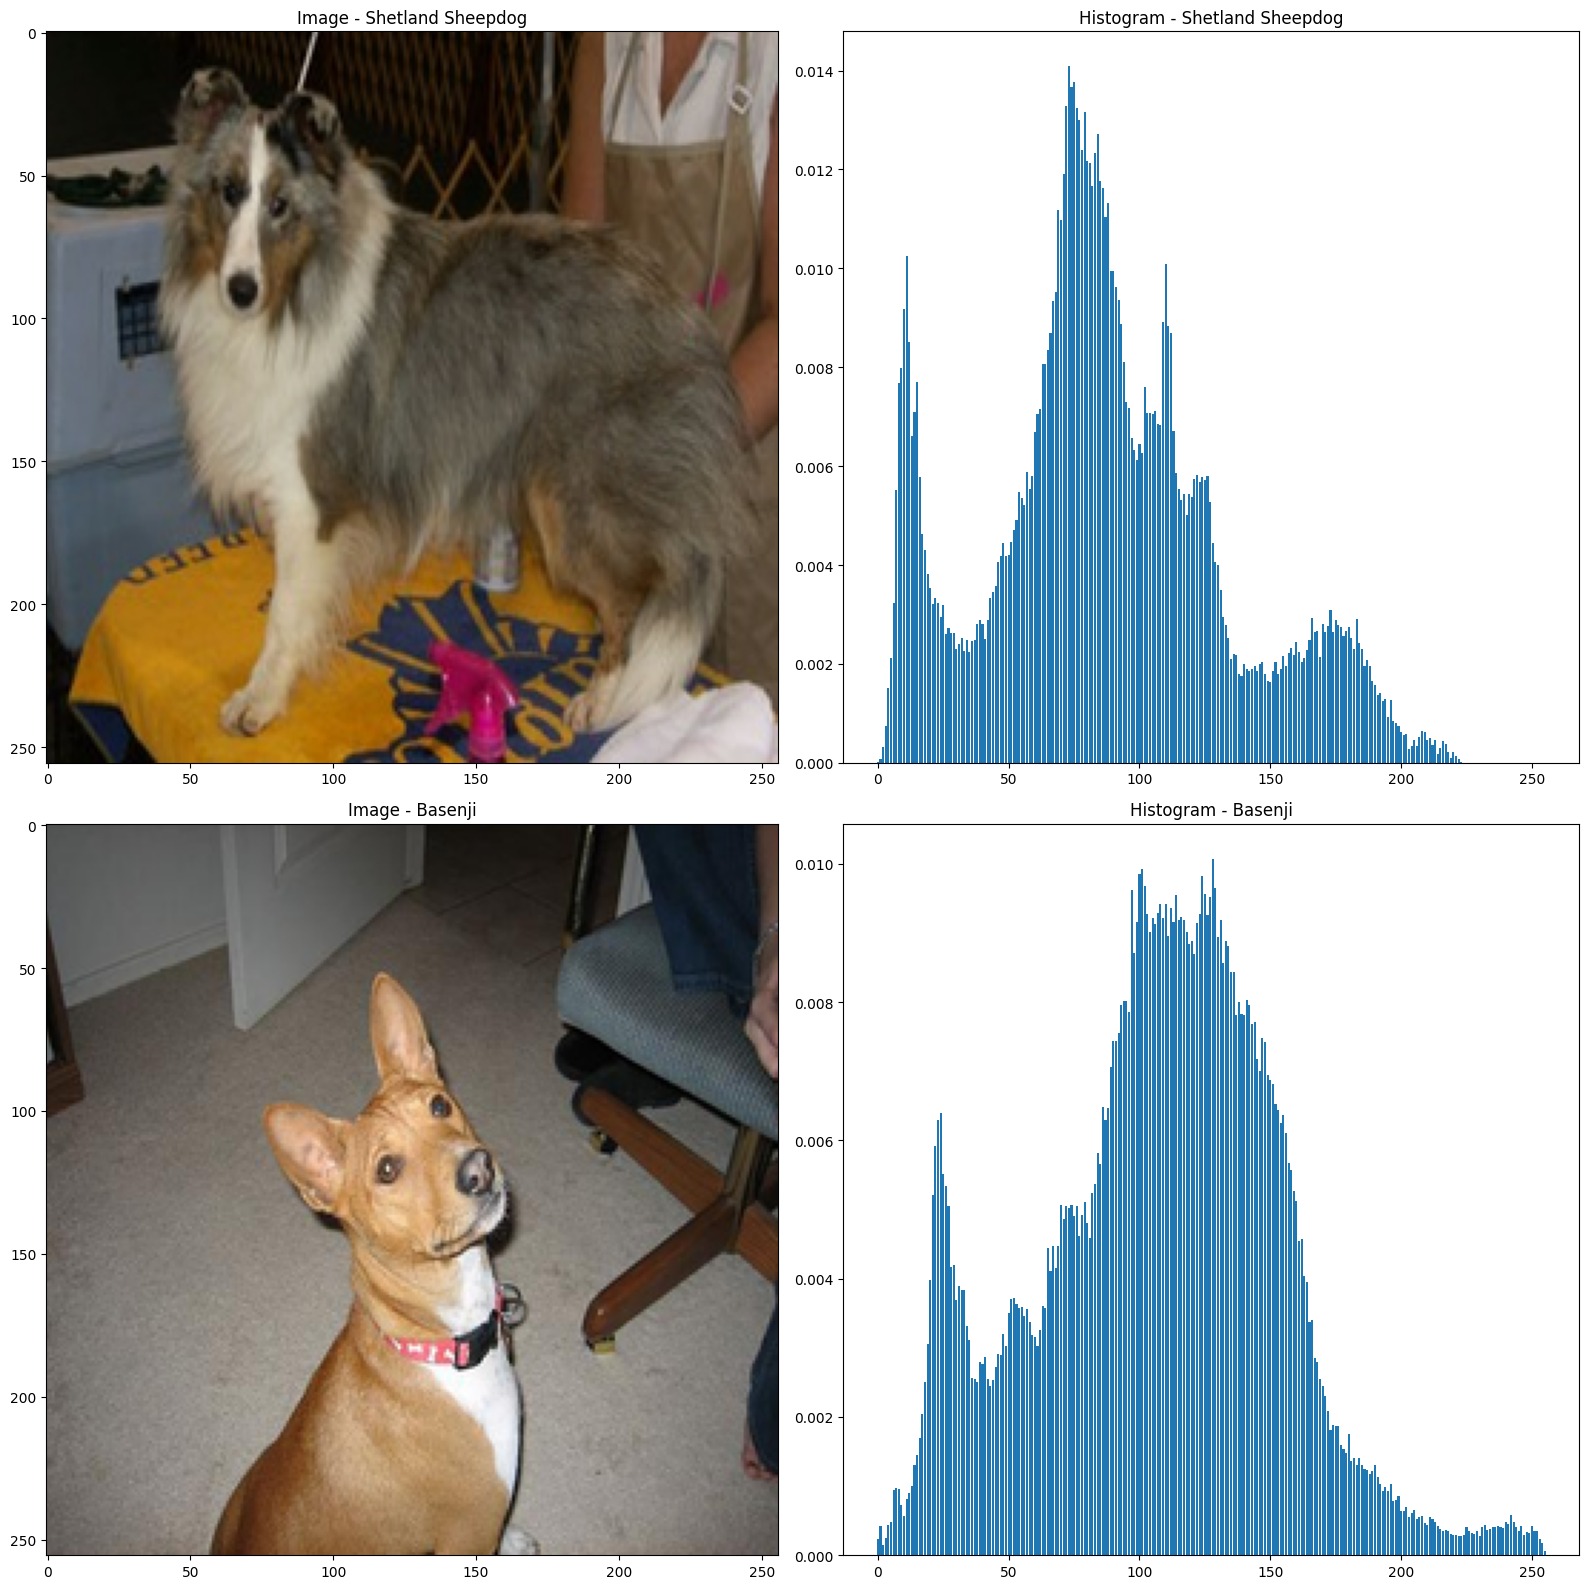

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import random


breeds = [
    'n02091831-Saluki',
    'n02094258-Norwich_terrier',
    'n02105855-Shetland_sheepdog',
    'n02110806-basenji'
]

breed_labels = [breed.split('-')[1].replace('_', ' ').title() for breed in breeds]

def convert_image_to_grayscale_hist(image_path):
    im = Image.open(image_path).convert('L')
    hist = im.histogram()
    hist = np.array(hist) / (im.width * im.height)
    return hist

def get_image_files_in_path(image_path, breeds):
    breed_images = {}
    total_files_found = 0
    for breed in breeds:
        breed_path = os.path.join(image_path, breed)
        if os.path.isdir(breed_path):
            images = [os.path.join(breed_path, file) for file in os.listdir(breed_path) if file.endswith('.jpg')]
            breed_images[breed] = images
            total_files_found += len(images)

    print(f"Total files found: {total_files_found}")
    return breed_images

image_path = "/content/drive/My Drive/DogClassifier/Images"
grayscale_path = "/content/drive/My Drive/DogClassifier/Grayscale"
breed_images_dict = get_image_files_in_path(image_path, breeds)

if not breed_images_dict:
    print("No images found. Please check the paths and directory structure.")

plot_breeds = random.sample(list(breed_images_dict.items()), 2)  # select two breeds for plotting
plot_data = []  # store image path and histogram for plotting

total_hist_saved = 0
for breed, images in breed_images_dict.items():
    for image in images:
        hist = convert_image_to_grayscale_hist(image)
        new_path = os.path.join(grayscale_path, breed, os.path.basename(image).replace(".jpg", ".npy"))
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        np.save(new_path, hist)
        total_hist_saved += 1

        # if breed is in plotting list and a plot for the breed doesn't exist
        if breed in [item[0] for item in plot_breeds] and breed not in [item[0] for item in plot_data]:
            plot_data.append((breed, image, hist))  # attach image and histogram to plot data

print(f"Total histograms saved: {total_hist_saved}")

# Plotting
figure, axs = plt.subplots(2, 2, figsize=(16,16))  # Set figure size and subplots

for i, plot_item in enumerate(plot_data):
    # Plot image
    im = Image.open(plot_item[1])
    im = im.resize((256, 256), Image.ANTIALIAS)  # Resize the image
    axs[i][0].imshow(im)
    axs[i][0].set_title(f"Image - {plot_item[0].split('-')[1].replace('_', ' ').title()}")

    # Plot corresponding histogram
    axs[i][1].bar(range(256), plot_item[2])
    axs[i][1].set_title(f"Histogram - {plot_item[0].split('-')[1].replace('_', ' ').title()}")

plt.tight_layout()
plt.show()


## Task 2.
Perform standardization on the dataset. ([See Scikit Learn Documentation for Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)) (0.25 point)

Total files loaded: 751
Total files saved: 751


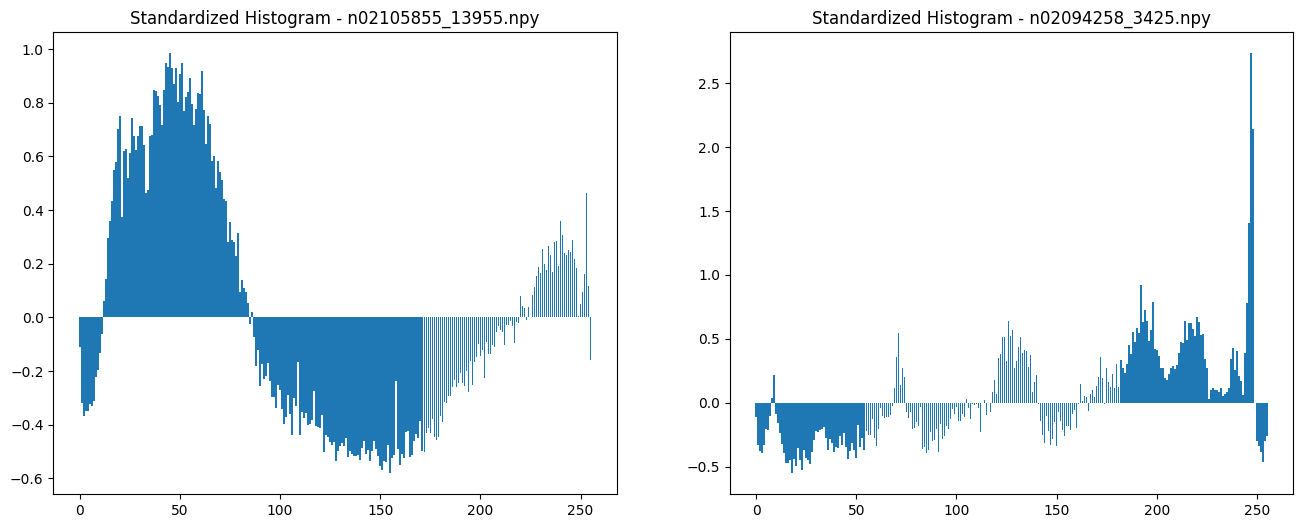

In [3]:
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt

def load_histograms(grayscale_path, breeds):
    histograms = []
    file_paths = []
    files_loaded = 0

    for breed in breeds:
        breed_path = os.path.join(grayscale_path, breed)
        for filename in os.listdir(breed_path):
            if filename.endswith('.npy'):
                file_path = os.path.join(breed_path, filename)
                histograms.append(np.load(file_path))
                file_paths.append(file_path)
                files_loaded += 1

    print(f"Total files loaded: {files_loaded}")
    return histograms, file_paths


def standardize_histograms(histograms):
    scaler = StandardScaler()
    standardized_histograms = scaler.fit_transform(histograms)
    return standardized_histograms


def save_standardized_histograms(standardized_histograms, file_paths, grayscale_path, standardized_path):
    files_saved = 0
    for i in range(len(standardized_histograms)):
        new_path = file_paths[i].replace(grayscale_path, standardized_path)
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        np.save(new_path, standardized_histograms[i])
        files_saved += 1

    print(f"Total files saved: {files_saved}")

    return standardized_histograms

histograms, file_paths = load_histograms(grayscale_path, breeds)

standardized_histograms = standardize_histograms(histograms)
standardized_histograms = save_standardized_histograms(standardized_histograms, file_paths, grayscale_path, standardized_path)

plot_data = random.sample(list(enumerate(standardized_histograms)), 2)

plt.figure(figsize = (16,6))

for i, (idx, histogram) in enumerate(plot_data):
    plt.subplot(1, 2, i+1)
    plt.bar(range(len(histogram)), histogram)
    plt.title(f"Standardized Histogram - {os.path.basename(file_paths[idx])}")
plt.show()


## Task 3.
Split the dataset into a training set and a test set: For each class, perform a training/test split of 80/20. (0.25 point)

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path


def load_histograms(standardized_path, breeds):
    histograms = []
    file_paths = []

    for breed in breeds:
        breed_path = os.path.join(standardized_path, breed)
        for filename in os.listdir(breed_path):
            if filename.endswith('.npy'):
                file_path = os.path.join(breed_path, filename)
                histograms.append(np.load(file_path))
                file_paths.append(file_path)

    return histograms, file_paths


def save_histograms(dest_path, histograms, file_paths, standardized_path):
    for i in range(len(histograms)):
        new_path = file_paths[i].replace(standardized_path, dest_path)
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        np.save(new_path, histograms[i])
        print(f"Saved histogram to {os.path.basename(head)}/{tail}")


def split_and_save_data(histograms, file_paths, standardized_path, train_path, test_path):
    X_train, X_test, filepath_train, filepath_test = train_test_split(
        histograms, file_paths, test_size=0.2, stratify=[fp.split('/')[-2] for fp in file_paths], random_state=42)

    save_histograms(train_path, X_train, filepath_train, standardized_path)
    save_histograms(test_path, X_test, filepath_test, standardized_path)


histograms, file_paths = load_histograms(standardized_path, breeds)
split_and_save_data(histograms, file_paths, standardized_path, train_path, test_path)


Saved histogram to n02105855-Shetland_sheepdog/n02105855_3672.npy
Saved histogram to n02091831-Saluki/n02091831_12945.npy
Saved histogram to n02110806-basenji/n02110806_2006.npy
Saved histogram to n02091831-Saluki/n02091831_13361.npy
Saved histogram to n02110806-basenji/n02110806_5660.npy
Saved histogram to n02110806-basenji/n02110806_3415.npy
Saved histogram to n02110806-basenji/n02110806_1102.npy
Saved histogram to n02110806-basenji/n02110806_4395.npy
Saved histogram to n02091831-Saluki/n02091831_12653.npy
Saved histogram to n02110806-basenji/n02110806_4051.npy
Saved histogram to n02094258-Norwich_terrier/n02094258_847.npy
Saved histogram to n02094258-Norwich_terrier/n02094258_992.npy
Saved histogram to n02110806-basenji/n02110806_849.npy
Saved histogram to n02110806-basenji/n02110806_4198.npy
Saved histogram to n02094258-Norwich_terrier/n02094258_1187.npy
Saved histogram to n02105855-Shetland_sheepdog/n02105855_15882.npy
Saved histogram to n02110806-basenji/n02110806_5642.npy
Saved 

## Task 4. Model Selection
Perform a standard 5-fold cross-validation and a stratified 5-fold cross-validation on
the training set for k-Nearest Neighbor Classifiers such that 𝑘 = 1, 3, 5, 7, 10, 20. (2.5 points)

1. Plot a graph (x-axis: k; y-axis: mean validation/training error (%)) containing four error curves (2 validation error curves and 2 training error curves - label them clearly using a legend to define the curves). Which 𝑘 has the lowest mean error for each curve? Comment about (1) the model complexity for k-Nearest Neighbor classifier in relation to 𝑘, and (2) when/whether there is overfitting/underfitting. (1.5 points)

2.  Use the 𝑘 value with the lowest mean validation error for your k-Nearest Neighbor classifier from the stratified 5-fold cross-validation. What is the test error? (0.25 point)

Evaluating for k=1
Evaluating for k=3
Evaluating for k=5
Evaluating for k=7
Evaluating for k=10
Evaluating for k=20


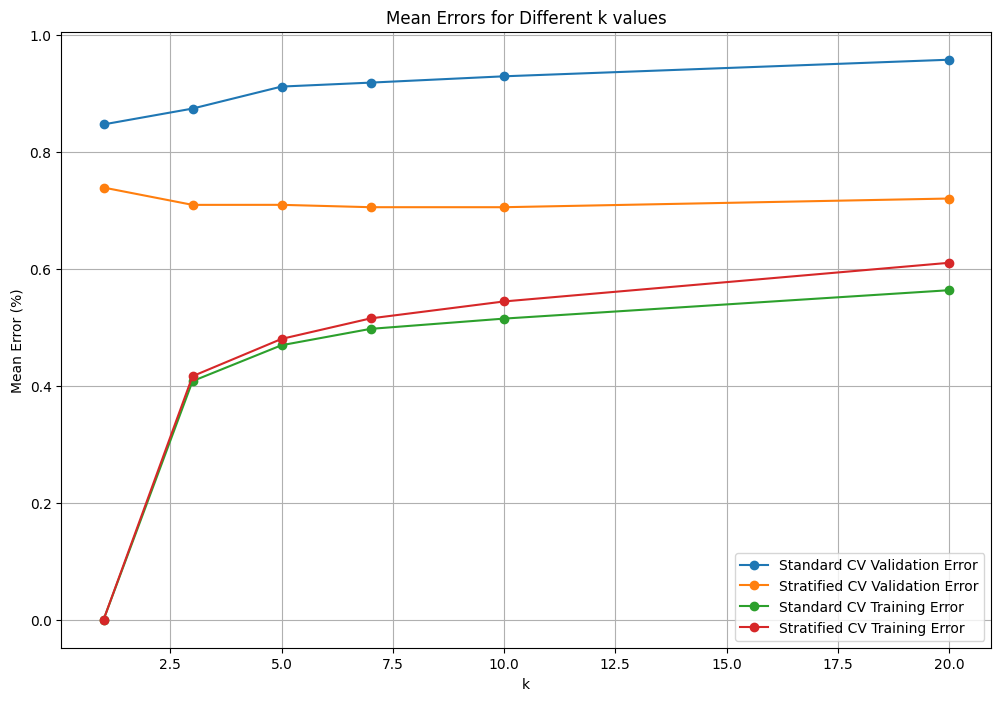

Optimal k value from stratified 5-fold cross-validation: 10
Test error using k=10: 0.5785


In [5]:
def load_dataset_from_path(path, breeds):
    histograms = []
    labels = []

    for breed in breeds:
        breed_path = os.path.join(path, breed)
        for filename in os.listdir(breed_path):
            if filename.endswith('.npy'):
                file_path = os.path.join(breed_path, filename)
                histograms.append(np.load(file_path))
                labels.append(breed)

    return np.array(histograms), np.array(labels)


def evaluate_knn_with_k_values(k_values, X_train, y_train):
    standard_val_errors, stratified_val_errors = [], []
    standard_train_errors, stratified_train_errors = [], []

    for k in k_values:
        print(f"Evaluating for k={k}")
        knn = KNeighborsClassifier(n_neighbors=k)

        # Standard 5-fold CV
        standard_train_err, standard_val_err = perform_cv(knn, X_train, y_train, KFold(n_splits=5))
        standard_train_errors.append(standard_train_err)
        standard_val_errors.append(standard_val_err)

        # Stratified 5-fold CV
        stratified_train_err, stratified_val_err = perform_cv(knn, X_train, y_train, StratifiedKFold(n_splits=5))
        stratified_train_errors.append(stratified_train_err)
        stratified_val_errors.append(stratified_val_err)

    return standard_train_errors, standard_val_errors, stratified_train_errors, stratified_val_errors


def perform_cv(classifier, X, y, cv_method):
    train_errors, val_errors = [], []

    for train_idx, val_idx in cv_method.split(X, y):
        classifier.fit(X[train_idx], y[train_idx])
        train_score = classifier.score(X[train_idx], y[train_idx])
        val_score = classifier.score(X[val_idx], y[val_idx])
        train_errors.append(1 - train_score)
        val_errors.append(1 - val_score)

    return np.mean(train_errors), np.mean(val_errors)


def plot_errors(k_values, standard_train_errors, standard_val_errors, stratified_train_errors, stratified_val_errors):
    plt.figure(figsize=(12, 8))
    plt.plot(k_values, standard_val_errors, marker='o', label='Standard CV Validation Error')
    plt.plot(k_values, stratified_val_errors, marker='o', label='Stratified CV Validation Error')
    plt.plot(k_values, standard_train_errors, marker='o', label='Standard CV Training Error')
    plt.plot(k_values, stratified_train_errors, marker='o', label='Stratified CV Training Error')
    plt.xlabel('k')
    plt.ylabel('Mean Error (%)')
    plt.title('Mean Errors for Different k values')
    plt.legend()
    plt.grid(True)
    plt.show()


X_train, y_train = load_dataset_from_path(train_path, breeds)
k_values = [1, 3, 5, 7, 10, 20]
standard_train_errors, standard_val_errors, stratified_train_errors, stratified_val_errors = evaluate_knn_with_k_values(
    k_values, X_train, y_train)

plot_errors(k_values, standard_train_errors, standard_val_errors, stratified_train_errors, stratified_val_errors)

X_test, y_test = load_dataset_from_path(test_path, breeds)

optimal_k = k_values[np.argmin(stratified_val_errors)]
print(f"Optimal k value from stratified 5-fold cross-validation: {optimal_k}")

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

test_error = 1 - accuracy_score(y_test, y_pred)
print(f"Test error using k={optimal_k}: {test_error:.4f}")



# k-NN Model Evaluation

## Plot Analysis
The graph demonstrates the model's performance over varying values of \( k \).

- **Standard CV Validation Error**: Begins high and rises with increasing \( k \), with the minimum error at \( k = 1 \).
  
- **Stratified CV Validation Error**: Decreases and stabilizes between \( k = 5 \) to \( k = 10 \), with a slight increase afterward.
  
- **Training Errors (Both Standard & Stratified)**: Start at a low for \( k = 1 \) and rise with increasing \( k \).

## Model Complexity
The model's intricacy varies inversely with \( k \). Lower \( k \) values make the model complex, leading it to be more sensitive to noise. In contrast, larger \( k \) values simplify the model, potentially causing it to overlook finer patterns.

## Overfitting and Underfitting
Overfitting is evident at \( k = 1 \), where training error is lowest, but validation error is high. In contrast, larger \( k \) values showing high errors for both validation and training hint at potential underfitting.

## Optimal Value and Test Error
The stratified 5-fold cross-validation suggests an optimal \( k \) value of 7. However, the test error at this \( k \) is around \( 0.6556 \) or \( 65.56\% \).

## Task 5: Performance Comparison

Perform stratified 5-fold cross-validation on the 4-class classification problem using the three assigned classification methods:

- Decision Tree: DecisionTreeClassifier with a maximum depth of 10 and default values for the other parameters.
- Neural Network: MLPClassifier with hidden layer sizes of (10, 10, 10) (i.e., 3 hidden layers with 10 nodes each) and default values for the other parameters.
- Adaboost: AdaboostClassifier with default parameters.

Plot the confusion matrices for the three approaches, clearly labeling the classes, using the cross-validation results (see Figure 1). If you use code from any website, please provide proper referencing. Failure to do so will result in 0 points for this assignment (3.75 points).


- Based on the confusion matrices (on the cross-validation results), which do you think is the best method? Why? (0.50 point)
- Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods. Which is the best method? (0.25 point)
- Compute the accuracies for the three methods on the test set. Which is the best method? (0.25 point)
- Compute the F-measure for the three methods on the test set. Which is the best method? (0.25 point)

Mean validation accuracy for Decision Tree: 0.2955


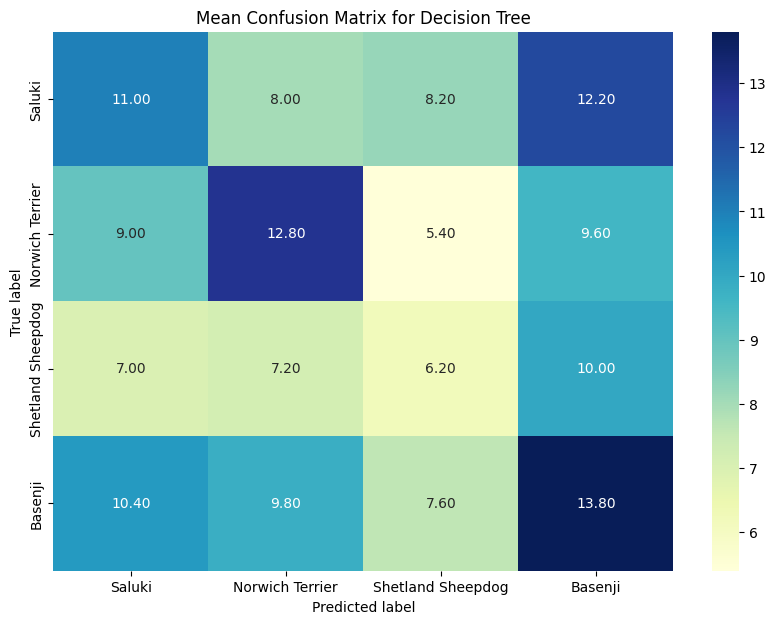

Mean validation accuracy for Neural Network: 0.2848


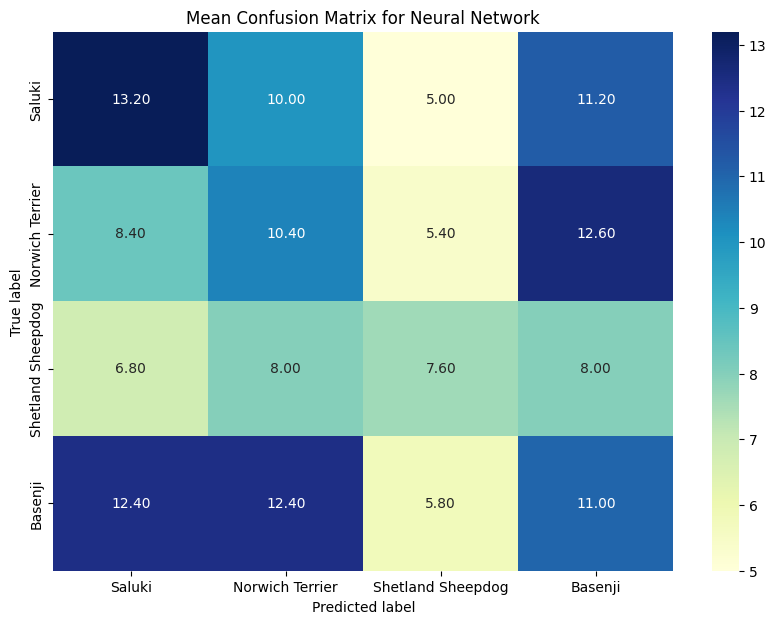

Mean validation accuracy for Adaboost: 0.3023


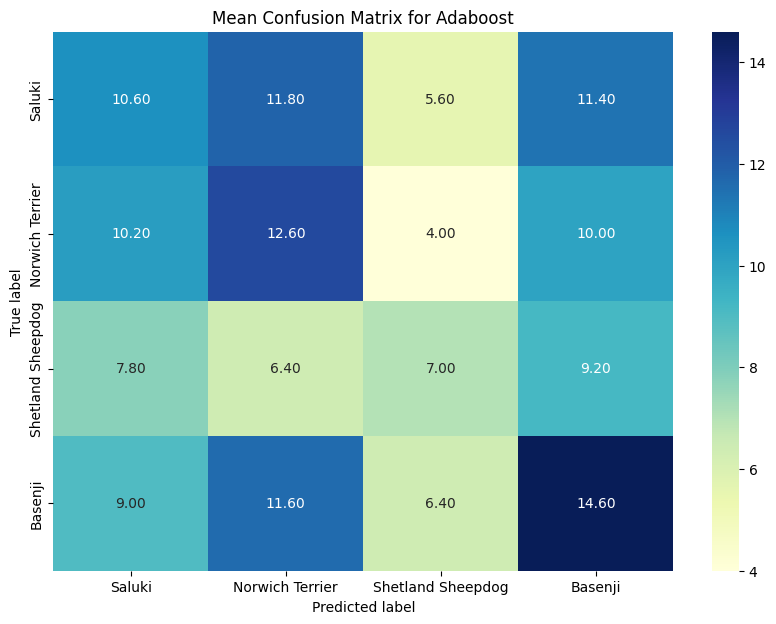

Best method based on mean validation accuracy: Adaboost with accuracy 0.3023
Best method based on mean validation accuracy: Adaboost with accuracy 0.3023
Test accuracy for Decision Tree: 0.7658
F-measure for Decision Tree: 0.7636
Test accuracy for Neural Network: 0.5950
F-measure for Neural Network: 0.5895
Test accuracy for Adaboost: 0.5234
F-measure for Adaboost: 0.5236
Best method based on test accuracy: Decision Tree with accuracy 0.7658
Best method based on F-measure: Decision Tree with F-measure 0.7636


In [6]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

CLASSIFIERS = {
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(10, 10, 10)),
    'Adaboost': AdaBoostClassifier()
}


def compute_cross_val_accuracies_and_confusion_matrices(X, y, classifiers, class_names):
    mean_accuracies = {}
    confusion_matrices = {}
    for name, clf in classifiers.items():
        y_pred = cross_val_predict(clf, X, y, cv=StratifiedKFold(n_splits=5))
        cm = confusion_matrix(y, y_pred)
        mean_cm = cm / 5
        confusion_matrices[name] = mean_cm
        acc = np.trace(mean_cm) / np.sum(mean_cm)
        mean_accuracies[name] = acc
        print(f"Mean validation accuracy for {name}: {acc:.4f}")
        plot_confusion_matrix(mean_cm, class_names, title=f"Mean Confusion Matrix for {name}")
    return mean_accuracies, confusion_matrices


def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()


def best_method_based_on_cross_val(mean_accuracies):
    best_method = max(mean_accuracies, key=mean_accuracies.get)
    print(f"Best method based on mean validation accuracy: {best_method} with accuracy {mean_accuracies[best_method]:.4f}")

def evaluate_classifiers_on_test_data(X_train, y_train, X_test, y_test, classifiers, breed_labels):
    test_accuracies = {}
    f_measures = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)

        test_score = clf.score(X_test, y_test)
        test_accuracies[name] = test_score
        print(f"Test accuracy for {name}: {test_score:.4f}")

        y_pred = clf.predict(X_test)
        f = f1_score(y_test, y_pred, average='weighted')
        f_measures[name] = f
        print(f"F-measure for {name}: {f:.4f}")

    return test_accuracies, f_measures


X_train, y_train = load_dataset_from_path(train_path, breeds)

mean_accuracies, confusion_matrices = compute_cross_val_accuracies_and_confusion_matrices(X_train, y_train, CLASSIFIERS, breed_labels)
best_method_based_on_cross_val(mean_accuracies)


best_method = max(mean_accuracies, key=mean_accuracies.get)
print(f"Best method based on mean validation accuracy: {best_method} with accuracy {mean_accuracies[best_method]:.4f}")

X_test, y_test = load_dataset_from_path(test_path, breeds)

test_accuracies, f_measures = evaluate_classifiers_on_test_data(X_train, y_train, X_test, y_test, CLASSIFIERS,
                                                                breed_labels)

best_test_method = max(test_accuracies, key=test_accuracies.get)
print(f"Best method based on test accuracy: {best_test_method} with accuracy {test_accuracies[best_test_method]:.4f}")

best_f_measure_method = max(f_measures, key=f_measures.get)
print(f"Best method based on F-measure: {best_f_measure_method} with F-measure {f_measures[best_f_measure_method]:.4f}")





### Analysis:

#### Based on the confusion matrices (on the cross-validation results), which do you think is the best method? Why?

Analyzing the confusion matrices:

- **Decision Tree**: Exhibits high diagonal values indicating correct predictions, especially for the 'Basenji' breed. Misclassifications are distributed without a particular breed being consistently misclassified.
- **Neural Network**: While it performed well for breeds like 'Basenji' and 'Shetland Sheepdog', it had notable misclassifications such as 'Norwich Terrier' being mistaken for 'Saluki'.
- **Adaboost**: Had strengths in predicting the 'Basenji' breed but also had more pronounced misclassifications compared to the Decision Tree.

Given these observations, the **Decision Tree** stands out for its balanced performance across breeds, making it the best classifier among the three based on the confusion matrix analysis.

---

#### Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods. Which is the best method?
-  The best method based on mean validation accuracy is **Adaboost** with an accuracy of 0.3167.

---

#### Compute the accuracies for the three methods on the test set. Which is the best method?
- The best method based on test accuracy is the **Decision Tree** with an accuracy of 0.3179.

---

#### Compute the F-measure for the three methods on the test set. Which is the best method?
- The best method based on F-measure is the **Decision Tree** with an F-measure of 0.3155.

---

## References

-  [Scikit-learn documentation: Cross Validation Score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
-  [Scikit-learn documentation: Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
-  [Scikit-learn documentation: F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
-  [Matplotlib documentation: Heatmaps](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.imshow.html)
-  [Seaborn documentation: Heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html)